# Introduction to NLP functions in TensorFlow

In [1]:
# Check for GPU

In [2]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
# Get helper Functions
!wget https://raw.githubusercontent.com/joe-seth/TensorFlow-Food-prediction-Computer-Vision-Project/main/extras/script_functions.py

--2023-12-03 16:33:06--  https://raw.githubusercontent.com/joe-seth/TensorFlow-Food-prediction-Computer-Vision-Project/main/extras/script_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10267 (10K) [text/plain]
Saving to: ‘script_functions.py’

script_functions.py 100%[===================>]  10.03K  --.-KB/s    in 0s      

2023-12-03 16:33:07 (76.3 MB/s) - ‘script_functions.py’ saved [10267/10267]



In [4]:
# Import series of helper functions from  the file
from script_functions import unzip_data, create_tensorboard_callback, plot_loss_curve, compare_historys

## Get the text dataset
The data that I'm going to be using is Kaggle's introduction to NLP dataset (text samples of tweets, labelled as disaster or not disaster)

In [5]:
# Unzip the data
unzip_data('/content/nlp-getting-started.zip')

## Visualize the text data

In [6]:
# import libraries
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_df['text'][26]

'Was in NYC last week!'

In [8]:
# Shuffle training data
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [9]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
# How many total samples
len(train_df), len(test_df)

(7613, 3263)

In [11]:
# Visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # Create random indexes not higher than the total number of samples
for row in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target : {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n {text}\n")
  print("___\n")

Target : 1 (real disaster)
Text:
 The Murderous Story Of AmericaÛªs First Hijacking: Earnest PletchÛªs cold-blooded killing ofÛ_ http://t.co/B9JAxx0vCf

___

Target : 1 (real disaster)
Text:
 Hm MT @Ebolatrends: Alabama Home Quarantined Over Possible Ebola Case http://t.co/ihVMtmZXne http://t.co/jLieMrSnnj

___

Target : 0 (not real disaster)
Text:
 This nigga Cyhi diss was what Meek was suppose to do. This shit actually fire

___

Target : 0 (not real disaster)
Text:
 has NOT sunk in that i leave for school in a month

___

Target : 1 (real disaster)
Text:
 Virgin galactic crash: early unlocking of brakes triggered structural failure - Irish Examiner http://t.co/ocMCvfDZkv

___



In [12]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [13]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
 # Check the first 10
 train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

In [15]:
# Convert text to numbers
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default tokenization parameters
text_vectorizer = TextVectorization(max_tokens = None,
                                    standardize = 'lower_and_strip_punctuation',
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode = "int",
                                    output_sequence_length = None,
                                    pad_to_max_tokens = False,
                                    vocabulary= None)


In [16]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [17]:
# Setup text Vectorization variables
max_vocab_length = 10000 # Max number of words to have in our vocabulary
max_length = 15 # Max length our sequence will be (eg. how many words will our )

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [18]:
# Fit the text vectorizer to the training set
text_vectorizer.adapt(train_sentences)

In [19]:
# Create sample sentence and tokenize it
sample_sentence = "There are floods in Kenya right now!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  74,   22,  207,    4, 3707,  179,   48,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [20]:
# Choose a random sentences from the trainin dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
\n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 Reddit Will Now Quarantine OffensiveåÊContent http://t.co/Gllawb2FSk http://t.co/3kaAfuoztc

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 273,   38,   48,  417, 3570,    1,    1,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [21]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() #get all the unique words in our training data
top_5_words = words_in_vocab[:5] # the most common words
bottom_5_words = words_in_vocab[-5:] # least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 common words : {top_5_words}")
print(f"Least common words : {bottom_5_words}")

Number of words in vocab: 10000
5 common words : ['', '[UNK]', 'the', 'a', 'in']
Least common words : ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [22]:
train_sentences

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       ...,
       'Near them on the sand half sunk a shattered visage lies... http://t.co/0kCCG1BT06',
       "kesabaran membuahkan hasil indah pada saat tepat! life isn't about waiting for the storm to pass it's about learning to dance in the rain.",
       "@ScottDPierce @billharris_tv @HarrisGle @Beezersun I'm forfeiting this years fantasy football pool out of fear I may win n get my ass kicked"],
      dtype=object)

## Creating an Embedding using an Embedding layer
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

In [23]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length, #set input shape
                             output_dim = 128,
                             embeddings_initializer='uniform',
                             input_length=max_length # how long is each input
)

embedding



In [24]:
# Get a random sentences from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
\n\nEmbedded version:")

# Embed the random sentence(turn it into dense vectors  of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 If I could I would have been by at work but got injured and we have security concerns they must settle. This is torture.

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.0115324 ,  0.02469659,  0.00604814, ...,  0.03848064,
         -0.022839  , -0.01777412],
        [ 0.04297812, -0.0489956 , -0.02436583, ..., -0.01280916,
         -0.01486618,  0.01849136],
        [-0.02338526,  0.01355832,  0.01195813, ...,  0.01845998,
         -0.04921594, -0.03317025],
        ...,
        [-0.03264945, -0.03490226,  0.04756118, ...,  0.03254286,
          0.01779768, -0.01910107],
        [ 0.00646442,  0.03586323,  0.02421952, ..., -0.0395847 ,
          0.03997238,  0.0450096 ],
        [-0.0303484 , -0.00055677, -0.01024586, ...,  0.0316281 ,
          0.0223688 , -0.01801731]]], dtype=float32)>

In [25]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.0115324 ,  0.02469659,  0.00604814, -0.01383076, -0.01014809,
         0.02976097, -0.04998292, -0.00882345, -0.02838423, -0.04026061,
         0.02368529,  0.04542721,  0.02939541,  0.04184954,  0.01997215,
         0.02103663, -0.01584405, -0.02599351, -0.00422714,  0.00185493,
         0.04981819,  0.00934117, -0.01256092, -0.02079738,  0.02645235,
        -0.02702811, -0.00330358,  0.00417677, -0.01103663,  0.02726612,
         0.03860012, -0.03185233,  0.01441269,  0.0129425 ,  0.03060411,
        -0.03458633,  0.04685625, -0.03655765, -0.01766205,  0.00288801,
        -0.00700976, -0.0263026 , -0.04368212,  0.02617482,  0.04183969,
         0.04640868, -0.02084656, -0.01656433, -0.02550111,  0.02131084,
         0.04649682,  0.04590087, -0.0435145 , -0.04195713, -0.04653912,
         0.01416666,  0.03890404, -0.02409488,  0.04247321,  0.02449324,
         0.02273767,  0.02520389, -0.04149476,  0.04001992,  0.01151476,
  

## Modelling text data
Turn the text sequence into numbers and start building a series of modeling experiments.
* Model 0: Naive Bayes (baseline), this is from SKLearn ML map
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM Model (RNN)
* Model 3: GRU Model (RNN)
* Model 4: Biderectional-LSTM model(RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6 TensorFlow Hbb pretrained Feature Extractor (Using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training


### Standard steps
* Create a model
* Build a model
* Fit a model
* Evaluate a model

### Model 0: Getting a baseline (baseline for future experiments)
Use Sklearns Mulitinomial Naive bayes using the TensorFlow IDF formula to convert words into numbers.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()), # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Evaluate the model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of : {baseline_score * 100:.2f}%")

Our baseline model achieves an accuracy of : 79.27%


In [28]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [29]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Create  a function for evaluating the metrics

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    confusion_mat = confusion_matrix(y_true, y_pred)

    print(f"Evaluation metrics for {model_name}:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Create a DataFrame from confusion matrix for better display
    confusion_df = pd.DataFrame(confusion_mat, columns=['Predicted 0', 'Predicted 1'],
                                index=['Actual 0', 'Actual 1'])

    # Plotting the confusion matrix with seaborn heatmap
    plt.figure(figsize=(6, 4))  # Adjust figure size as needed
    sns.set(font_scale=1.2)  # Adjust font scale as needed
    sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


Evaluation metrics for Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())]):
Accuracy: 79.27%
Precision: 0.8861788617886179
Recall: 0.6264367816091954
F1 Score: 0.734006734006734


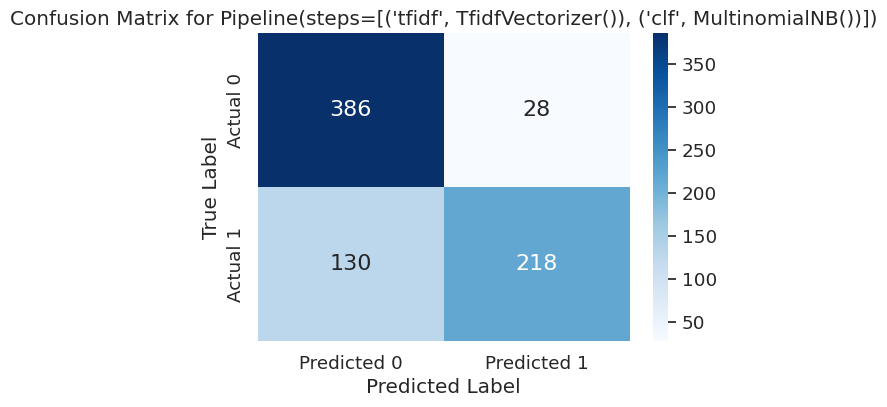

In [31]:
baseline_results = evaluate_model(model_0, val_labels, baseline_preds)

### Model_1: Build a simple dense model

In [32]:
# Create  a tensorboard callback(need to create a new one for each model)
from script_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [33]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [34]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [35]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [36]:
# Fit the model

model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20231203-163315
Epoch 1/5
215/215 [==============================] - 6s 25ms/step - loss: 0.6100 - accuracy: 0.6895 - val_loss: 0.5336 - val_accuracy: 0.7638
Epoch 2/5
215/215 [==============================] - 5s 24ms/step - loss: 0.4412 - accuracy: 0.8196 - val_loss: 0.4724 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 5s 21ms/step - loss: 0.3464 - accuracy: 0.8615 - val_loss: 0.4568 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 5s 25ms/step - loss: 0.2842 - accuracy: 0.8920 - val_loss: 0.4657 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 5s 23ms/step - loss: 0.2370 - accuracy: 0.9127 - val_loss: 0.4849 - val_accuracy: 0.7835


In [37]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4849 - accuracy: 0.7835


[0.4848949611186981, 0.7834645509719849]

In [38]:
# Make predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[0]

24/24 [==============================] - 0s 3ms/step


array([0.34762368], dtype=float32)

In [39]:
# Look at the first 10 predictions
model_1_pred_probs[:10]

array([[0.34762368],
       [0.7372188 ],
       [0.99753934],
       [0.12453324],
       [0.11483354],
       [0.9326916 ],
       [0.90350515],
       [0.99361336],
       [0.9584309 ],
       [0.28289664]], dtype=float32)

In [40]:
# Converte model prediction probabilities to label format
model_1_pred_probs = tf.squeeze(tf.round(model_1_pred_probs))
model_1_pred_probs[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

Evaluation metrics for <keras.src.engine.functional.Functional object at 0x7fa4e2ca5120>:
Accuracy: 78.35%
Precision: 0.823321554770318
Recall: 0.6695402298850575
F1 Score: 0.7385103011093502


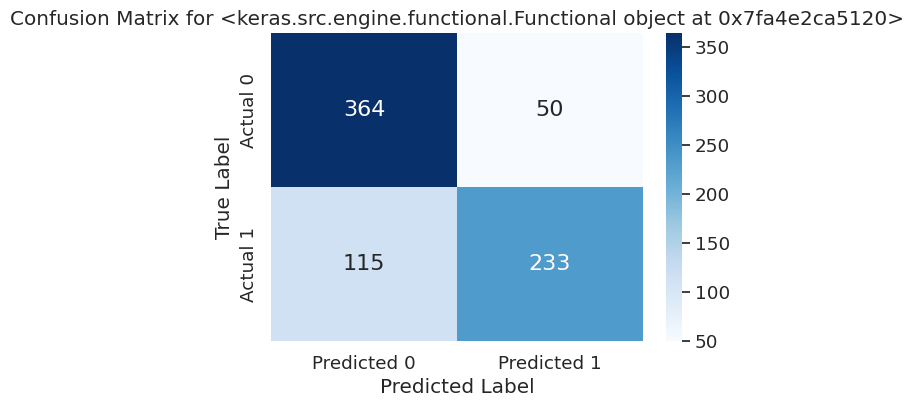

In [41]:
# Calcutate our model_1 predictions
model_1_results = evaluate_model(model_name = model_1,
                                 y_true=val_labels,
                                 y_pred=model_1_pred_probs)

## Visualize learned embeddings

In [42]:
# Get the vocabulary from the text vectoriizer layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [43]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [44]:
# Get the weight matix of embedding layer
# These are the numerical representation of each token in our training  data which have been learned for 5 epochs
embed_weights  = model_1.get_layer("embedding").get_weights()
embed_weights

[array([[-0.04245238, -0.00139343,  0.02908472, ..., -0.03864952,
         -0.02166409, -0.0509919 ],
        [-0.03914372,  0.04566845,  0.0244646 , ...,  0.021717  ,
         -0.02464447, -0.01798577],
        [-0.02030311,  0.04106265, -0.02720348, ..., -0.00394991,
         -0.06035018, -0.03082551],
        ...,
        [ 0.00446438, -0.02909495, -0.03840118, ..., -0.03597321,
          0.01521561, -0.03043933],
        [-0.05193869,  0.06089898,  0.06854118, ...,  0.07802797,
         -0.06210141, -0.04236051],
        [-0.10596714,  0.03408637,  0.0203771 , ...,  0.07688811,
         -0.03822357, -0.08710135]], dtype=float32)]

> Visualize using projector: https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin

In [45]:
# Visualize using the projector
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.plugins import projector

In [46]:
import io

# Create output writers
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')


# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
    if num == 0:
        continue  # skip 0, it's padding token
    vec = embed_weights[num]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()


IndexError: ignored

In [47]:
len(embed_weights)

1

# Recurrent Neural Network
RNN's are useful for sequence data.
The premise of a current neural network is to  use the representation of a previous input to aid the representation of a later input

### Model 2: LSTM
Long Short Term Memory

In [48]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x) # When stacking l
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
x = layers.Reshape((-1, 1))(x)
x = layers.LSTM(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')


(None, 15, 128)
(None, 15, 64)
(None, 64)


In [49]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [50]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data = (val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20231203-163409
Epoch 1/5
215/215 [==============================] - 27s 94ms/step - loss: 0.4298 - accuracy: 0.8977 - val_loss: 0.5105 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 17s 81ms/step - loss: 0.1875 - accuracy: 0.9380 - val_loss: 0.5434 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 18s 82ms/step - loss: 0.1449 - accuracy: 0.9498 - val_loss: 0.7316 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 18s 82ms/step - loss: 0.1194 - accuracy: 0.9581 - val_loss: 0.6494 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 19s 87ms/step - loss: 0.0928 - accuracy: 0.9661 - val_loss: 0.6842 - val_accuracy: 0.7756


In [51]:
# Make prediction
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 2s 23ms/step


array([[0.07062691],
       [0.9313413 ],
       [0.9999833 ],
       [0.07758503],
       [0.00668756],
       [0.9856703 ],
       [0.9886588 ],
       [0.99997926],
       [0.99996257],
       [0.27128536]], dtype=float32)

In [52]:
# Convert model 2  pred probs to labels
model_2_pred_probs = tf.squeeze(tf.round(model_2_pred_probs))
model_2_pred_probs[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

Evaluation metrics for <keras.src.engine.functional.Functional object at 0x7fa50d724d00>:
Accuracy: 77.56%
Precision: 0.8
Recall: 0.6781609195402298
F1 Score: 0.734059097978227


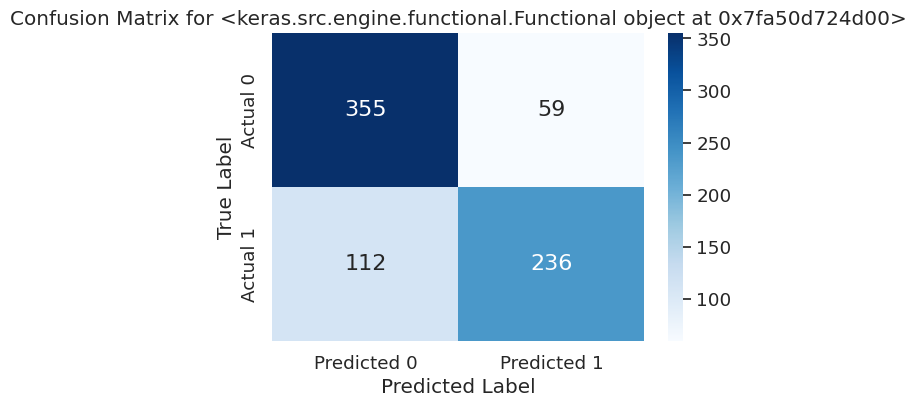

In [53]:
# Calculate model 2  results
model_2_results = evaluate_model(model_2,
                                 y_true=val_labels,
                                 y_pred = model_2_pred_probs)
model_2_results

## Model 3: GRU

In [54]:
# Build and RNN using GRU cell

# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [55]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [56]:
# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [57]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data= (val_sentences, val_labels),
                              callbacks =[create_tensorboard_callback(SAVE_DIR,
                                                                       "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20231203-163640
Epoch 1/5
215/215 [==============================] - 11s 38ms/step - loss: 0.5261 - accuracy: 0.7291 - val_loss: 0.4535 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 8s 35ms/step - loss: 0.3196 - accuracy: 0.8675 - val_loss: 0.4864 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 8s 37ms/step - loss: 0.2187 - accuracy: 0.9181 - val_loss: 0.5596 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 7s 34ms/step - loss: 0.1573 - accuracy: 0.9454 - val_loss: 0.6162 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 8s 36ms/step - loss: 0.1200 - accuracy: 0.9594 - val_loss: 0.6028 - val_accuracy: 0.7756


In [59]:
# Make Predictions
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 5ms/step


array([[0.35008875],
       [0.8849941 ],
       [0.9964483 ],
       [0.12623121],
       [0.01391571],
       [0.9866765 ],
       [0.6337489 ],
       [0.9971783 ],
       [0.9964562 ],
       [0.43298522]], dtype=float32)

In [60]:
# Convert Model_3 pred probs to lables
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0

Evaluation metrics for <keras.src.engine.functional.Functional object at 0x7fa4d7767f10>:
Accuracy: 77.56%
Precision: 0.7739938080495357
Recall: 0.7183908045977011
F1 Score: 0.7451564828614008


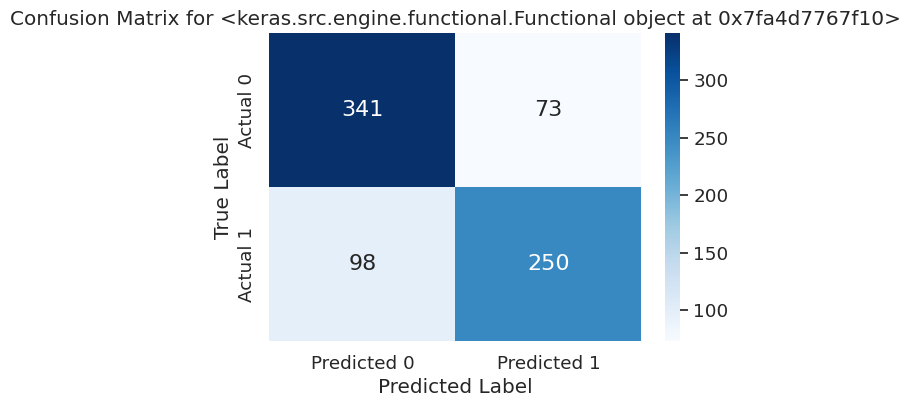

In [61]:
# Calculate model 3 resuults
model_3_results = evaluate_model(model_3, val_labels, model_3_preds)

In [62]:
# Build model Using Bi directional Neural network
from tensorflow.keras.layers import Bidirectional
model_4_embedding = layers.Bidirectional()

In [ ]:
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(10, return_sequences=True),
                             input_shape=(5, 10)))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')